In [10]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from dPCA import dPCA
from get_utils import get_data, get_dir
import numpy as np
import plot as plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch as th
#%matplotlib widget
#%matplotlib qt
%matplotlib inline

fontsize_label = 18
fontsize_tick = 15
fontsize_legend = 20
save_fig = '/Users/mahdiyar/Diedrichsenlab Dropbox/Mahdiyar Shahbazi/Conferences/NCM2024_Mahdiyar/figures'

In [3]:
folder_name = 'Sim_all_128'

# Load data
phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}

ts = []

for mn in range(20):

    model_name = 'model{:02d}'.format(mn)

    U = get_data(folder_name,model_name,phase,ff_coef=None) #,batch_size=300,catch_trial_perc=0,condition='train',go_cue_random=False

    n_muscle = 6
    weight_file,_,_= get_dir(folder_name,model_name,'NF1',0)
    W = th.load(weight_file)['fc.weight'].numpy()
    _, _, Vh = np.linalg.svd(W, full_matrices=True)
    V = Vh.T
    P = V[:,:n_muscle].T # output potent: ...x neurons
    N = V[:,n_muscle:].T # output null space: ...x neurons

    data = []
    for i in range(len(U)):
        data.append(np.array(U[i]['all_hidden'])) # size: n_trials x n_timepoints x n_neurons   (8, 100, 128)

    X = np.concatenate([d[:,None,:,:] for d in data], axis=1)
    X = X.transpose(3,0,1,2) # neurons x conditions x phase x time

    # remove the overall mean
    X = X - np.mean(X, axis=(1,2,3))[:,None,None,None]

    # project into the output potent space
    X = np.einsum('ij,jklm->iklm', N, X)

    X_1 = X[:,:,:2,:]
    X_2 = X[:,:,2:,:]

    dpca = dPCA.dPCA(labels='clt',join={'ct':['c','ct'], 'lt':['l','lt'], 'clt':['cl','clt']},n_components=6,n_iter=0) 
    dpca.protect = ['t']
    dpca.fit(X_1)
    Z = dpca.transform(np.concatenate((X_1,X_2),axis=2))
    #Z = dpca.transform(X_2)

    x = []
    for i in range(Z['lt'].shape[2]):
        x.append(np.mean(Z['lt'][:,:,i,:].transpose(1,2,0)[:,:,0],axis=0))
    x = np.array(x)
    ts.append(x)
ts = np.array(ts)
ts_avg = np.mean(ts,axis=0)

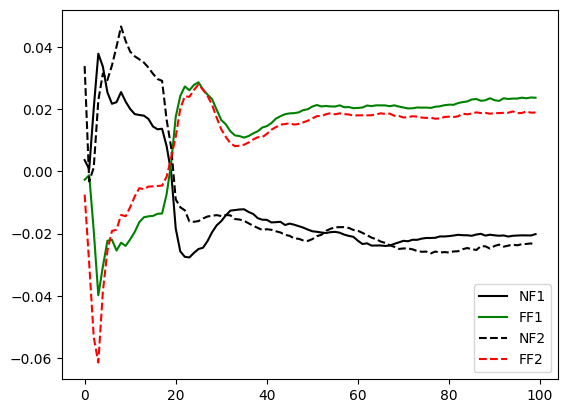

In [4]:
linestyle = ['-', '-', '--', '--']
color_list = ['k','g','k','r']
label=['NF1','FF1','NF2','FF2']

fig,ax = plt.subplots(1,1)
for i in range(len(x)):
    ax.plot(ts_avg[i,:].T,color=color_list[i],label=label[i],linestyle=linestyle[i])
    #ax.plot(x[i][:,:,0].T,linestyle=linestyle[i])
ax.legend()

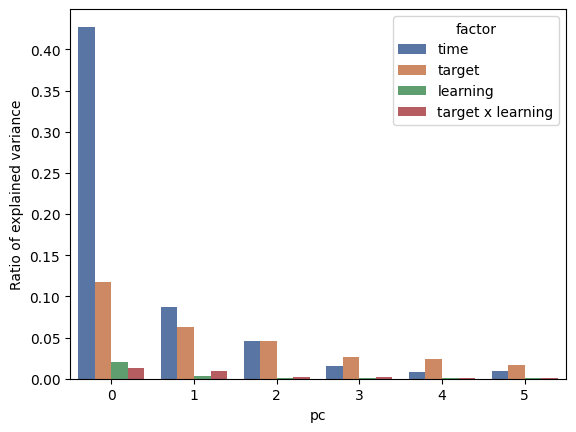

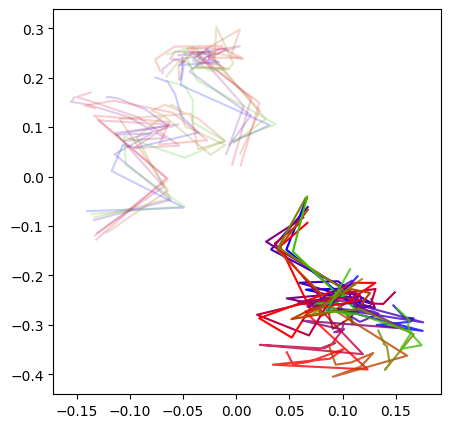

In [5]:
#names = ['time','target','learning','learningxtime','target x learning']
names = ['time','target','learning','target x learning']
var = dpca.explained_variance_ratio_
var_df = pd.DataFrame(columns=['factor', 'pc', 'variance_explained'])

counter = 0
for i,name in enumerate(var.keys()):
    for c in range(dpca.n_components):
        var_df.loc[counter] = {'factor': names[i], 'pc': c,'variance_explained': var[name][c]}
        counter += 1

# Plot
fig,ax = plt.subplots()
sns.barplot(var_df, x='pc', y='variance_explained', hue='factor', palette=sns.color_palette('deep',4))
ax.set_ylabel('Ratio of explained variance')


x = []
for i in range(Z['lt'].shape[2]):
    x.append(Z['lt'][:,:,i,:].transpose(1,2,0))


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111) #, projection='3d'

plot.plot_traj(ax,x,which_times=list(range(0,10)),plot_scatter=0,dim=2,alpha=[1,0.2,0.8,0.2])

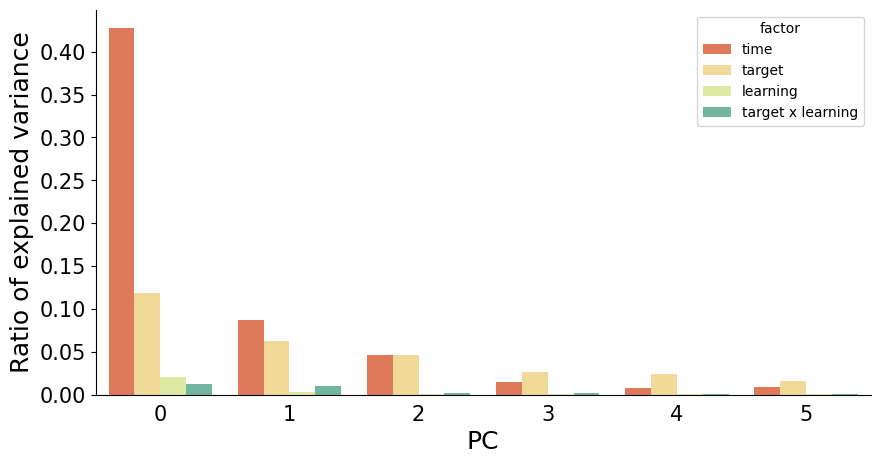

In [14]:
# Plot
fig,ax = plt.subplots(1,1,figsize=(10,5))
sns.barplot(var_df, x='pc', y='variance_explained', hue='factor', palette=sns.color_palette('Spectral',4))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#ax.set_xticklabels([])
#ax.set_yticklabels([])

ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)

ax.tick_params(bottom = False) 
ax.set_xlabel('PC', fontsize = fontsize_label)
ax.set_ylabel('Ratio of explained variance', fontsize = fontsize_label)

fig.savefig(os.path.join(save_fig,'dpca.pdf'),dpi=300,bbox_inches='tight')

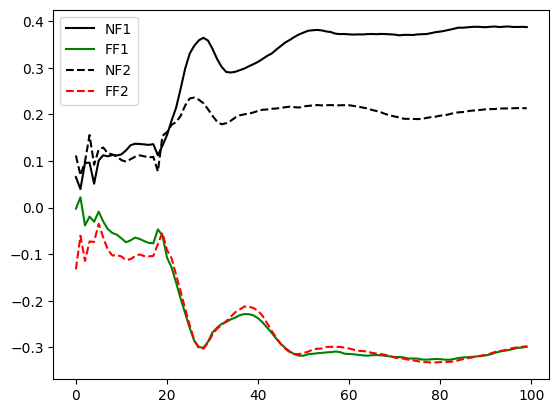

In [6]:
linestyle = ['-', '-', '--', '--']
color_list = ['k','g','k','r']
label=['NF1','FF1','NF2','FF2']

fig,ax = plt.subplots(1,1)
for i in range(len(x)):
    ax.plot(np.mean(x[i][:,:,0],axis=0).T,color=color_list[i],label=label[i],linestyle=linestyle[i])
    #ax.plot(x[i][:,:,0].T,linestyle=linestyle[i])
ax.legend()